In [45]:
# Cell 1) 환경 설정: 경로 변수
pred_file       = "runs/train/Yolov5n-rgbt-mosaic0.5-withAnotherAugment-mixup0.1/epoch14_predictions.json"    # YOLOv5 예측 결과 JSON
image_list_file = "datasets/kaist-rgbt/val-split-byOPT.txt"         # 예측 대상 이미지 목록 TXT
label_dir       = "datasets/kaist-rgbt/train/labels"                      # YOLO 형식 라벨(.txt)이 있는 디렉토리
img_dir         = "datasets/kaist-rgbt/train/images/visible"                      # 실제 이미지(.jpg 등)가 있는 디렉토리
img_lwir_dir    = "datasets/kaist-rgbt/train/images/lwir"
iou_thresh      = 0.5                                     # IoU 기준값


In [46]:
# Cell 2) 라이브러리 import 및 IoU 함수 정의
import os, json
import cv2
import matplotlib.pyplot as plt

def compute_iou(box1, box2):
    """box = [x, y, w, h] 절대좌표 → IoU 반환"""
    x1,y1,w1,h1 = box1
    x2,y2,w2,h2 = box2
    xa1,ya1,xa2,ya2 = x1, y1, x1+w1, y1+h1
    xb1,yb1,xb2,yb2 = x2, y2, x2+w2, y2+h2
    xi1, yi1 = max(xa1, xb1), max(ya1, yb1)
    xi2, yi2 = min(xa2, xb2), min(ya2, yb2)
    iw, ih = max(0, xi2-xi1), max(0, yi2-yi1)
    inter = iw * ih
    union = w1*h1 + w2*h2 - inter
    return inter/union if union>0 else 0

In [47]:
# Cell 3) 예측 결과 및 이미지 목록 로딩
with open(pred_file, 'r') as f:
    preds = json.load(f)

# preds: list of dict, dict["image_name"], dict["bbox"] = [x,y,w,h]
preds_by_img = {}
for p in preds:
    name = p["image_name"]
    preds_by_img.setdefault(name, []).append(p["bbox"])

# 이미지 목록(txt) → 경로, basename 추출
lines       = [L.strip() for L in open(image_list_file)]
image_paths = [os.path.join(img_dir, os.path.basename(L)) for L in lines]
image_names = [os.path.splitext(os.path.basename(p))[0] for p in image_paths]

In [92]:
# Cell 4) GT 읽기 및 시각화 함수 정의
def load_gt_boxes(img_path):
    """YOLO txt → 절대좌표 [x,y,w,h] 리스트 반환"""
    img = cv2.imread(img_path)
    H,W = img.shape[:2]
    base = os.path.splitext(os.path.basename(img_path))[0]
    label_file = os.path.join(label_dir, base + ".txt")
    boxes = []
    if os.path.isfile(label_file):
        for L in open(label_file):
            cls, xc,yc,wn,hn, _ = map(float, L.split())
            w_abs = wn * W;  h_abs = hn * H
            x_abs = xc*W;  y_abs = yc*H

            if cls != 0:
                cls = -1

            boxes.append([x_abs, y_abs, w_abs, h_abs, cls])
    return boxes

# Cell X) 수정된 visualize 함수: RGB + LWIR 나란히 시각화
def visualize(img_vis_path, gt_boxes, pred_boxes,
              img_lwir_dir, iou_thr=iou_thresh):
    """
    :param img_vis_path: RGB 이미지 경로
    :param gt_boxes:     GT 박스 리스트 [[x,y,w,h], ...]
    :param pred_boxes:   예측 박스 리스트 [[x,y,w,h], ...]
    :param img_lwir_dir: LWIR 이미지가 들어있는 디렉토리
    :param iou_thr:      IoU 기준
    """

    # 1) 이미지 로드
    vis_img = cv2.imread(img_vis_path)
    base    = os.path.splitext(os.path.basename(img_vis_path))[0]
    # LWIR는 흑백이므로 GRAY로 읽은 뒤 BGR로 변환
    lwir_path   = os.path.join(img_lwir_dir, base + ".jpg")
    lwir_gray   = cv2.imread(lwir_path, cv2.IMREAD_GRAYSCALE)
    lwir_img    = cv2.cvtColor(lwir_gray, cv2.COLOR_GRAY2BGR)

    # 2) GT별로 detection 여부 판정
    det, miss = [], []
    for gt in gt_boxes:
        best = max([compute_iou(gt[0:4], p) for p in pred_boxes] + [0])
        (det if best >= iou_thr else miss).append((gt, best))

    # 3) 박스 그리기 함수 (cls 값에 따라 색깔 분기)
    def draw_boxes(img, det, miss):
        canvas = img.copy()
        # 1) 잘 탐지된 GT
        for ((x, y, w, h, cls), iou) in det:
            x, y, w, h = map(int, (x, y, w, h))
            if cls == -1:
                color = (0, 127, 255)      # BGR 주황색 (탐지했는데, 탐지하면 안되는거)
            else:
                color = (0, 255, 0)      # BGR 초록색 (good)
            cv2.rectangle(canvas, (x, y), (x + w, y + h), color, 2)
            cv2.putText(canvas, f"{w}x{h}", (x, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            cv2.putText(canvas, f"iou:{round(iou,2)}", (x, y + h + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # 2) 놓친 GT
        for ((x, y, w, h, cls), iou) in miss:
            x, y, w, h = map(int, (x, y, w, h))
            if cls == -1:
                color = (255, 0, 0)      # BGR 파란색 (놓쳤는데, -1인거 -> 잘 된것)
            else:
                color = (0, 0, 255)      # BGR 빨강색
            cv2.rectangle(canvas, (x, y), (x + w, y + h), color, 2)
            cv2.putText(canvas, f"{w}x{h}", (x, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            cv2.putText(canvas, f"iou:{round(iou,2)}", (x, y + h + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        return canvas

    # 4) RGB / LWIR 모두에 적용
    vis_vis  = draw_boxes(vis_img,  det, miss)
    vis_lwir = draw_boxes(lwir_img, det, miss)

    # 4) Matplotlib으로 나란히 출력
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].imshow(cv2.cvtColor(vis_vis,  cv2.COLOR_BGR2RGB))
    axes[0].set_title("Visible")
    axes[1].imshow(cv2.cvtColor(vis_lwir, cv2.COLOR_BGR2RGB))
    axes[1].set_title("LWIR")
    for ax in axes: ax.axis("off")
    plt.tight_layout()
    plt.show()


In [49]:
# # Cell 5) 샘플 실행: 처음 5장만
# for img_path, name in zip(image_paths[:5], image_names[:5]):
#     print("Image:", name)
#     gt = load_gt_boxes(img_path)
#     preds_for_img = preds_by_img.get(name, [])
#     visualize(img_path, gt, preds_for_img)

In [100]:
# Cell 5) 랜덤 샘플 실행: 실제 GT(빈 파일 제외)가 있는 이미지 중 무작위 5장
import random

# 1) 라벨 파일에 실제 내용이 있는 이미지만 필터링
paths_with_gt = []
for p in image_paths:
    base       = os.path.splitext(os.path.basename(p))[0]
    label_file = os.path.join(label_dir, base + ".txt")
    # 빈 줄만 있거나 완전히 비어있으면 GT 없음으로 간주
    with open(label_file, 'r') as f:
        lines = [l for l in f if l.strip()]
    if lines:
        paths_with_gt.append(p)

Image: set02_V000_I01395


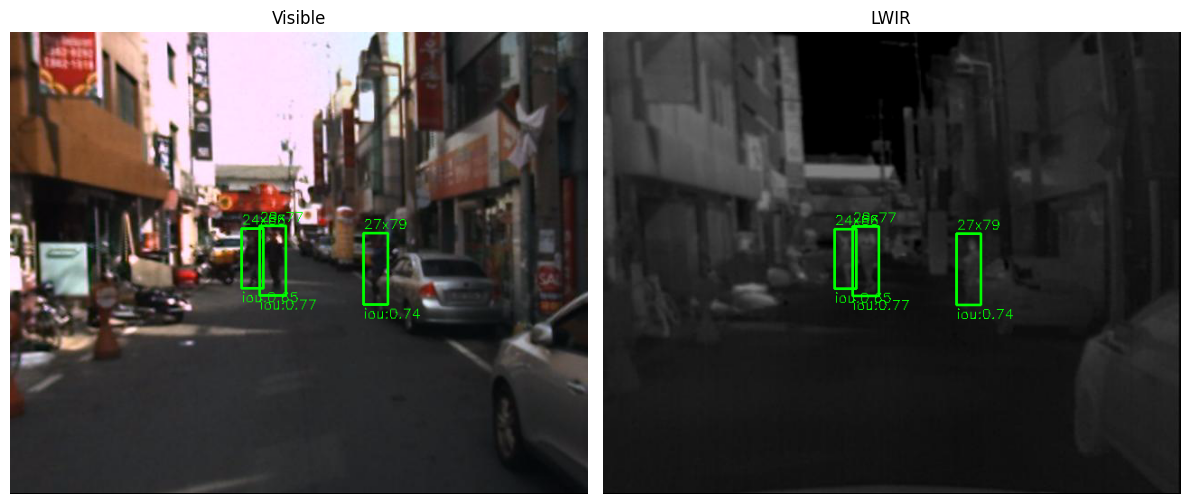

Image: set02_V000_I01559


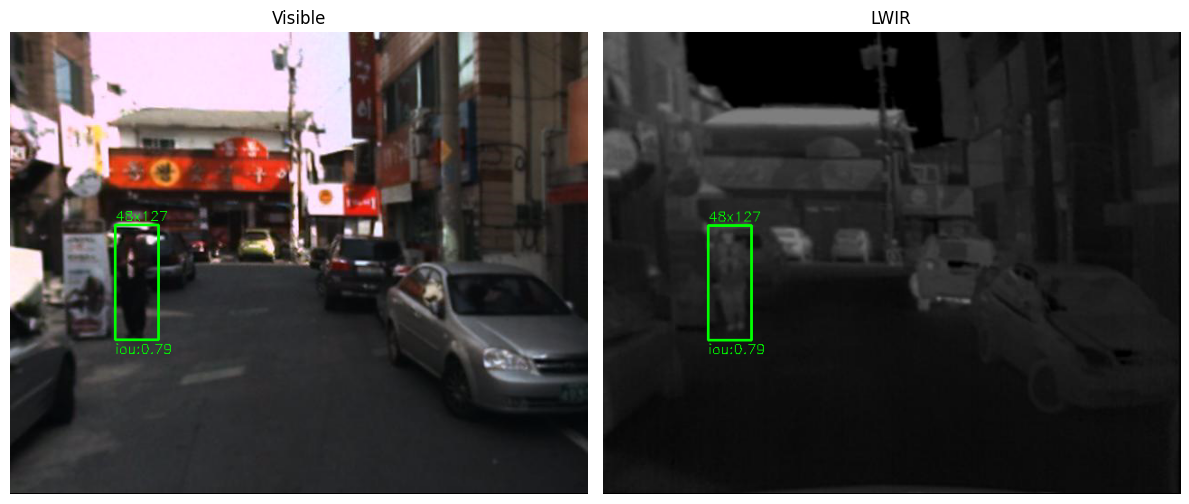

Image: set04_V001_I01159


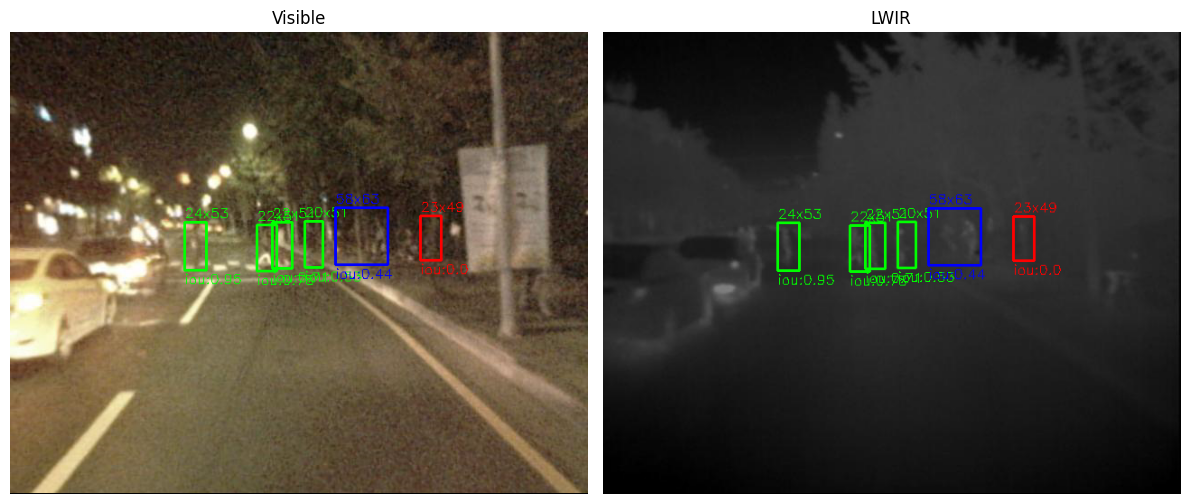

Image: set04_V001_I01207


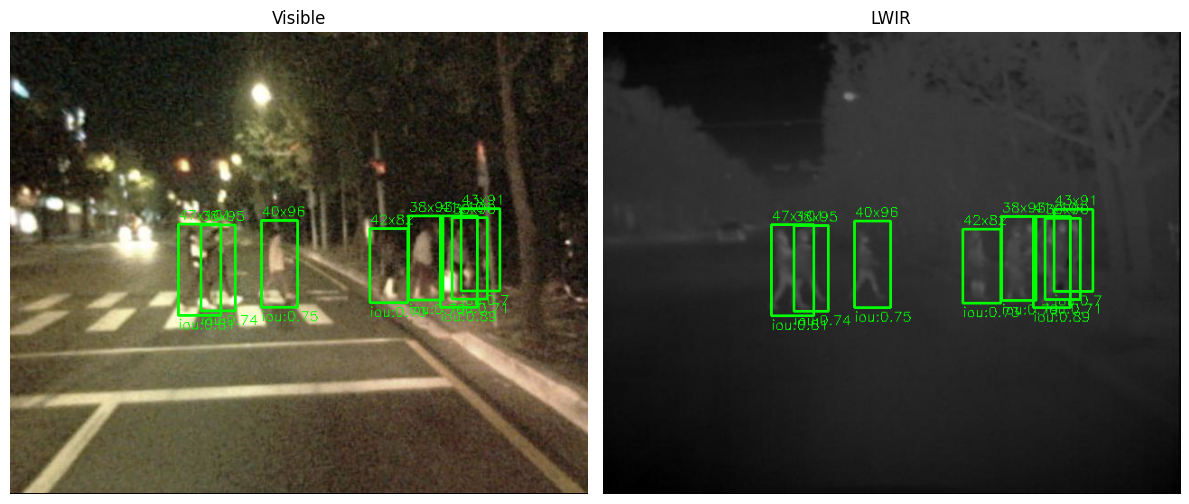

Image: set03_V001_I01807


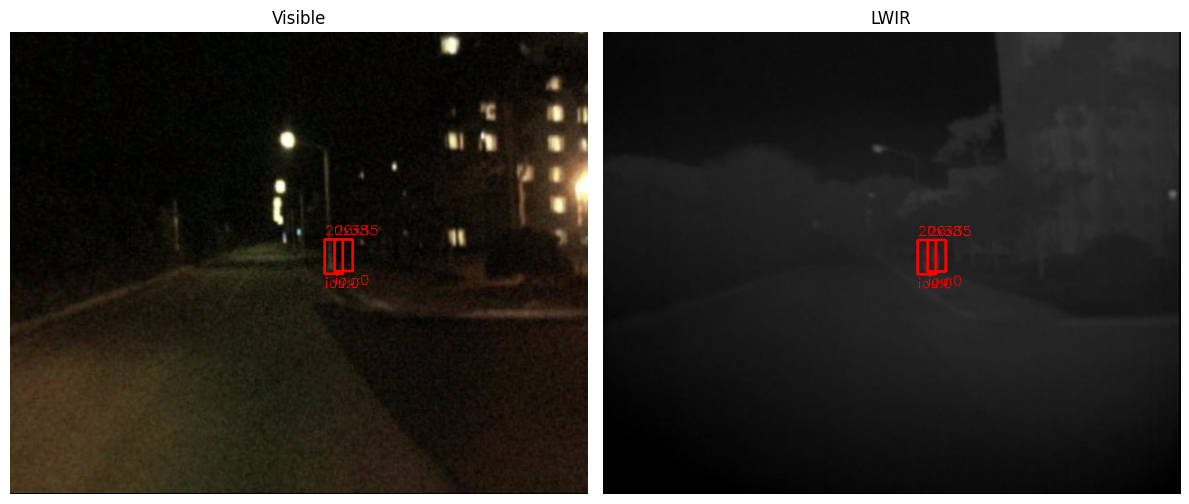

In [108]:
# 2) 최대 5장 랜덤 샘플링
sample_paths = random.sample(paths_with_gt, k=min(5, len(paths_with_gt)))

# 3) 각 샘플에 대해 시각화
for img_path in sample_paths:
    name         = os.path.splitext(os.path.basename(img_path))[0]
    print("Image:", name)
    gt           = load_gt_boxes(img_path)
    preds_for_img = preds_by_img.get(name, [])
    visualize(img_path, gt, preds_for_img, img_lwir_dir)